In [1]:
from dotenv import load_dotenv
import os
import pandas as pd
from time import time
import torch
from TextEnrichers import get_enricher, TextEnricher
from database.database import Database
from Embedders import Embedder, get_embedder
from tqdm import tqdm
from pprint import pprint
import numpy as np

load_dotenv(".env", override=True)

db = Database()
db.test_connection()

=================================CONFIG=================================
Database         User             Host                             Port            
citeline_db      bbasseri         localhost                        5432            
Database version: ('PostgreSQL 17.3 (Homebrew) on x86_64-apple-darwin23.6.0, compiled by Apple clang version 16.0.0 (clang-1600.0.26.6), 64-bit',)


In [2]:
device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.mps.is_available() else 'cpu'
print(f"Using device: {device}")
examples = pd.read_json('data/dataset/100/nontrivial.jsonl', lines=True)
print(f"Loaded {len(examples)} examples")

Using device: mps
Loaded 100 examples


In [3]:
def get_index_of_target(query_results, target_doi: str) -> int:
    """
    Get the index of the target DOI in the query results.
    :param query_results: The query results from the database.
    :param target_doi: The DOI of the target paper.
    :return: The index of the target DOI in the query results.
    """
    for i, result in enumerate(query_results):
        if result.doi == target_doi:
            return i
    return -1

def get_query_results_and_ranks(examples, embedder, enricher, target_column) -> list[int]:
    all_query_results = []
    target_ranks = []
    # Enrich and embed the sentences
    enriched_sentences = enricher(examples)
    embeddings = embedder(enriched_sentences)

    for i, embedding in tqdm(enumerate(embeddings)):
        pubdate = examples.iloc[i]['pubdate']
        target_doi = examples.iloc[i]['citation_dois'][0]

        query_results = db.query_vector_column(
            query_vector=embedding,
            table_name="lib",
            target_column=target_column,
            pubdate=pubdate,
            top_k=10_000,
            probes=40,
            explain=False,
        )
        all_query_results.append(query_results)

        # Get the rank of the target DOI in the query results
        target_rank = get_index_of_target(query_results, target_doi)
        target_ranks.append(target_rank)
    return all_query_results, target_ranks

In [4]:
# BGE with identity experiment
bge_embedder = get_embedder("BAAI/bge-small-en", device=device, normalize=True)
identity_enricher = get_enricher("identity", path_to_data="data/preprocessed/reviews.jsonl")

bge_query_results, bge_ranks = get_query_results_and_ranks(examples, bge_embedder, identity_enricher, "bge_norm")


100it [03:08,  1.89s/it]


In [6]:
def print_rank_stats(ranks):
    """
    Print the rank statistics.
    :param ranks: The ranks to analyze.
    """
    print(f"Mean rank: {np.mean(ranks)}")
    print(f"Median rank: {np.median(ranks)}")
    print(f"Max rank: {np.max(ranks)}")
    print(f"Rank 0 count: {ranks.count(0)}")
    print(f"Rank 1 count: {ranks.count(1)}")
    print(f"Rank 2 count: {ranks.count(2)}")
    print(f"Rank 3 count: {ranks.count(3)}")

print_rank_stats(bge_ranks)

Mean rank: 645.41
Median rank: 18.0
Max rank: 8045
Rank 0 count: 10
Rank 1 count: 10
Rank 2 count: 2
Rank 3 count: 2


In [8]:
failed_queries = [i for i in range(len(bge_ranks)) if bge_ranks[i] == -1]
print(f"Failed queries: {len(failed_queries)}")
print(failed_queries)

Failed queries: 18
[0, 8, 10, 11, 14, 23, 27, 40, 42, 46, 58, 65, 66, 68, 72, 78, 80, 93]


## Methodology

Each failed query represents an example query executed on the database with top-k of 10,000 and 40 probes where none of the results were chunks from the target document.

- Verify the target doi is correct
- If not, identify why not
  - would the correct doi have closer chunk embeddings?
- If correct, inspect what chunks were considered close
- What transformations, if any, would make the target chunk's embedding closer to the query vector?

Let's try with example 18, the worst-performing one in the dataset

In [10]:
example = examples.iloc[failed_queries[0]]
pprint(f"Original sentence: {example.sent_original}")
pprint(f"Example: {example.sent_no_cit}")
print(f"Target doi: {example.citation_dois}")

('Original sentence: These are minor species, with abundances of 1.5 10 12 , '
 '1.7 10 9 , and 7 10 8 kg N, respectively ( Ussiri and Lal, 2013 ).')
('Example: These are minor species, with abundances of 1.5 10 12 , 1.7 10 9 , '
 'and 7 10 8 kg N, respectively ( Ussiri and .')
Target doi: ['10.1016/j.epsl.2013.07.013']


This is an incorrect doi: the inline citation missed the first author. 

### Incorrect DOI

In [11]:
example = examples.iloc[failed_queries[1]]
pprint(f"Original sentence: {example.sent_original}")
pprint(f"Example: {example.sent_no_cit}")
print(f"Target doi: {example.citation_dois}")

('Original sentence: But assuming the existence of ad hoc density '
 'fluctuations, may change the volume integrated gamma-ray spectrum as to make '
 'it similar to the observed one Morlino and Caprioli ( 2012 ).')
('Example: But assuming the existence of ad hoc density fluctuations, may '
 'change the volume integrated gamma-ray spectrum as to make it similar to the '
 'observed one Morlino and .')
Target doi: ['10.1088/1475-7516/2012/07/038']


### Incorrect DOI

In [12]:
example = examples.iloc[failed_queries[2]]
pprint(f"Original sentence: {example.sent_original}")
pprint(f"Example: {example.sent_no_cit}")
print(f"Target doi: {example.citation_dois}")

('Original sentence: Sweatman (2021) ignored data from carbon spherules '
 'generated by both YDIH proponents and critics that provides one of the most '
 'compelling pieces of evidence against the YDIH.')
('Example: ignored data from carbon spherules generated by both YDIH '
 'proponents and critics that provides one of the most compelling pieces of '
 'evidence against the YDIH.')
Target doi: ['10.1016/j.gca.2021.07.031']


The doi actually refers to Sun et al 2021, not Sweatman 2021. The dataset build process should not have included an example where the year and author initial had more than one possibility

In [33]:
reviews = pd.read_json("data/preprocessed/reviews.jsonl", lines=True)
original_record = reviews[reviews['doi'] == example.source_doi].iloc[0]

In [34]:
for ref in original_record.reference:
    if ref[:4] == "2021" and ref[-1] == "S": 
        print(ref)

2021GeCoA.312...57S


That's the bibcode in the original review paper references that matched "2021" and "S". However, the bibcode for Sweatman (2021) is actually `2021ESRv..21803677S`. 

The bibcode for this inline citation is missing in the document's references:

In [35]:
for ref in original_record.reference:
    if ref[:4] == "2021":
        print(ref)


2021CliPa..17.1409N
2021EGUGA..23.8442T
2021GeCoA.312...57S
2021JGRD..12635379Z
2021MNRAS.501.3350F
2021NatCo..12.2106C
2021NatSR..1118632B
2021NatSR..1122359O
2021Natur.595...66R


### Conclusion: if this is a one-off error we can add the missing reference to the training data. 

In [37]:
example = examples.iloc[failed_queries[3]]
pprint(f"Original sentence: {example.sent_original}")
pprint(f"Example: {example.sent_no_cit}")
print(f"Target doi: {example.citation_dois}")

('Original sentence: Gyrochronology is based on the stellar spin-down due to '
 'magnetic braking and uses the surface rotation rate as a clock, adopting the '
 'so-called Skumanich relation between angular momentum loss and rotation '
 'rate, ( Skumanich 1972 ).')
('Example: Gyrochronology is based on the stellar spin-down due to magnetic '
 'braking and uses the surface rotation rate as a clock, adopting the '
 'so-called Skumanich relation between angular momentum loss and rotation '
 'rate, ( .')
Target doi: ['10.1086/151310']


This is the correct doi, so why didn't it come up?

The passage discusses:
- Gyrochronology being based on stellar spin-down
- Magnetic braking being the cause of the the spin-down
- Skumanich relation to compute this, which relates angular momentum loss and rotation rate

Is it in the dataset?

In [39]:
research = pd.read_json("data/preprocessed/research.jsonl", lines=True)

In [46]:
target_doi = example.citation_dois[0]
print(f"Target doi: {target_doi}")

target_record = research[research['doi'] == target_doi].iloc[0]
print(target_record.title)

Target doi: 10.1086/151310
Time Scales for Ca II Emission Decay, Rotational Braking, and Lithium Depletion


In [48]:
target_chunks = [chunk[0] for chunk in db.query(f"SELECT chunk FROM lib WHERE doi = '{target_doi}'")]
print(f"Number of chunks: {len(target_chunks)}")

Number of chunks: 6


In [50]:
from scipy.spatial.distance import cosine as cosine_distance
example_embedding = bge_embedder([example.sent_no_cit])[0]
chunk_embeddings = bge_embedder(target_chunks)
for i in range(len(target_chunks)):
    chunk = target_chunks[i]
    chunk_embedding = chunk_embeddings[i]
    distance = cosine_distance(example_embedding, chunk_embedding)
    pprint(f"Distance: {distance}")
    pprint(chunk)
    print()

'Distance: 0.1627938151359558'
('197 2ApJ. . .171. .565S The Astrophysical Journal, 171:565-567, 1972 '
 'February 1 © 1972. The University of Chicago All rights reserved. Printed in '
 'U S A TIME SCALES FOR Ca n EMISSION DECAY, ROTATIONAL BRAKING, AND LITHIUM '
 'DEPLETION A. Skumanich High Altitude Observatory, National Center for '
 'Atmospheric Research,* Boulder, Colorado Received 1971 June 21 ABSTRACT A '
 'comparison of the Ca+ emission luminosity—after correction for spectral-type '
 'effects—for the Pleiades, Ursa Major, and Hyades stars and the Sun indicate '
 'an emission decay which varies as the inverse square root of the age. '
 'Further, the rotational decay curve is found to satisfy the same law. It is '
 'further suggested that lithium depletion follows the+ same law but only as '
 'far as the Hyades age, after which the depletion proceeds exponentially. '
 'Since Ca emission is linearly proportional to magnetic field strength at the '
 'surface, one can predict that 

Even though this is the paper that established the Skumanich relation, all chunk embeddings are rather distant at 0.16 - 0.17.

What did the embedding think was more similar?

In [52]:
example_query_results = bge_query_results[failed_queries[3]]
for query_result in example_query_results[:3]:
    pprint(f"Distance: {query_result.distance}\n {query_result.chunk}")

('Distance: 0.09885724166455323\n'
 ' Stars like the Sun are believed to have been spun down by magnetic braking '
 '(Skumamch 1972). Magnetic dynamo models indicate that the braking rate '
 "decreases with decreasing angular velocity. Skumamch's surface velocity ~ ~c "
 't 1/2, where t is the age of the star, leads to a spin-down timescale of ;d '
 '°~ ~spin, 1187 1188 RASIO ET AL. Vol. 470 while the theory of Tout & Pringle '
 '(1992) for fully convective, rapidly rotating stars leads to the weaker, but '
 'still inverse, dependence of ;d °~ ~-i/2~ In general the tidal '
 'synchronization rate increases with the lack of synchronicity, ,rsu oc ~ ~, '
 'where A1~ is the difference between stellar spin and orbital angular '
 'velocities. If ;~ and ;d were both short compared with the age of the star, '
 'then an equilibrium would be set up in which ;~ ~ ;d* This is the case for '
 'cataclysmic variables, in which tidal spin-up and magnetic braking (or '
 'gravitational radiation of angu

Trying query expansion: use an LLM to generate paraphrases of the query that surface additional background details:

> 
You are a domain-expert astrophysical writer. When given any single input sentence in quotes, your job is to produce 3 concise, standalone paraphrases that:

1. Preserve **all** original technical details and domain-specific jargon.
2. **Explicitly expose** any implied mathematical relationships in algebraic form (e.g. y = x^{-1/2}).
3. **Cite or mention** at least one observational proxy or physical manifestation
4. Keep the same meaning and level of formality.
5. List each paraphrase on its own numbered line.

Input: "Gyrochronology is based on the stellar spin-down due to magnetic braking and uses the surface rotation rate as a clock, adopting the so-called Skumanich relation between angular momentum loss and rotation rate."

In [56]:
paraphrases = [
    """Gyrochronology employs stellar rotation period decay (via magnetic braking's angular momentum dissipation) as an age indicator, mathematically expressed as 
J
˙
∝
Ω
3
J
˙
 ∝Ω 
3
  (Skumanich relation), with surface differential rotation patterns serving as observational proxies for spin-down rates.
Exposed relationship: 
τ
∝
P
2
τ∝P 
2
  (age 
τ
τ vs. rotation period 
P
P) derived from 
J
∝
Ω
−
1
/
2
J∝Ω 
−1/2
 .""",
    """
Stellar age dating via gyrochronology quantifies magnetic braking-induced spin-down using the Skumanich law (
Ω
∝
t
−
1
/
2
Ω∝t 
−1/2
 ), where surface rotation modulation (observable through starspot periodicity) directly traces angular momentum loss rates.
Exposed relationship: 
L
bol
L 
bol
 -normalized Rossby number 
R
o
≡
P
/
τ
c
Ro≡P/τ 
c
  links convection timescales 
τ
c
τ 
c
  to magnetic activity proxies like Ca II H+K emission.
  """,
    """
Gyrochronological models calibrate stellar ages through the Skumanich-derived 
Ω
˙
∝
−
Ω
3
Ω
˙
 ∝−Ω 
3
  torque law, where photometric rotation period measurements (e.g., from Kepler light curve periodograms) serve as direct observational inputs for angular momentum evolution tracks.
Exposed relationship: 
Ω
(
t
)
=
Ω
0
(
1
+
t
/
τ
Sk
)
−
1
/
2
Ω(t)=Ω 
0
 (1+t/τ 
Sk
 ) 
−1/2
  with characteristic timescale 
τ
Sk
∼
10
−
100
τ 
Sk
 ∼10−100 Myr for solar-type stars.""",
]

In [57]:
paraphrase_embeddings = bge_embedder(paraphrases)
for i in range(len(paraphrases)):
    distance = cosine_distance(example_embedding, paraphrase_embeddings[i])
    pprint(f"Distance {i}: {distance}")

'Distance 0: 0.07871377468109131'
'Distance 1: 0.08848387002944946'
'Distance 2: 0.11988002061843872'


We see here that a couple of these paraphrases do very well against the example embedding, beating the 0.99 distance of the top-ranked query result. Does that hold on a full query against the database if `paraphrase_embedding[0]` had been used?

In [58]:
paraphrase_query_results = db.query_vector_column(
    query_vector=paraphrase_embeddings[0],
    table_name="lib",
    target_column="bge_norm",
    pubdate=example.pubdate,
    top_k=10_000,
    probes=40,
    explain=False,
)


In [60]:
get_index_of_target(paraphrase_query_results, example.citation_dois[0])

943

In [62]:
for chunk in target_chunks:
    print(chunk)
    print()

197 2ApJ. . .171. .565S The Astrophysical Journal, 171:565-567, 1972 February 1 © 1972. The University of Chicago All rights reserved. Printed in U S A TIME SCALES FOR Ca n EMISSION DECAY, ROTATIONAL BRAKING, AND LITHIUM DEPLETION A. Skumanich High Altitude Observatory, National Center for Atmospheric Research,* Boulder, Colorado Received 1971 June 21 ABSTRACT A comparison of the Ca+ emission luminosity—after correction for spectral-type effects—for the Pleiades, Ursa Major, and Hyades stars and the Sun indicate an emission decay which varies as the inverse square root of the age. Further, the rotational decay curve is found to satisfy the same law. It is further suggested that lithium depletion follows the+ same law but only as far as the Hyades age, after which the depletion proceeds exponentially. Since Ca emission is linearly proportional to magnetic field strength at the surface, one can predict that the surface fields are proportional to angular velocity and decay as the inverse 

In [65]:
example_embedding = bge_embedder([example.sent_no_cit])[0]

In [68]:
doc_expansions = [
    "The inverse square-root relationship between rotation rate and stellar age, remains foundational for modeling angular momentum loss via magnetized winds, though age revisions (e.g., van den Heuvel 1969) challenge the universality of this timescale",
    "Skumanich's correlation between Li abundance decay and rotational braking suggests a shared dependence on magnetic activity, implicating wind-driven spin-down in regulating interior mixing efficiency",
    "The proportionality between Ca II emission, rotation, and Li abundance (Skumanich 1972) underscores the role of dynamo-generated fields in shaping both surface activity and light-element depletion",
    "Discrepancies in Hyades' age estimates (van den Heuvel 1969) introduce uncertainties in power-law indices, necessitating multi-cluster analyses to disentangle rotational and chemical evolution",
    "While Skumanich's inverse power law fits young clusters, deviations in older systems hint at unresolved physics in late-stage angular momentum transport",
]

doc_embeddings = bge_embedder(doc_expansions)
for i in range(len(doc_expansions)):
    distance = cosine_distance(example_embedding, doc_embeddings[i])
    pprint(f"Distance {i}: {distance}")

'Distance 0: 0.10995858907699585'
'Distance 1: 0.1576480269432068'
'Distance 2: 0.16275274753570557'
'Distance 3: 0.18524116277694702'
'Distance 4: 0.15468883514404297'


Not great but much better!

### Conclusion: 
- the embedder will naturally consider chunks that cite the same sources as overly similar. 
- Paraphrasing the query to surface more background details brought the target doc under rank 1000
- Document expansion also improved matters somewhat

## Failure 4

In [69]:
example = examples.iloc[failed_queries[4]]
pprint(f"Original sentence: {example.sent_original}")
pprint(f"Example: {example.sent_no_cit}")
print(f"Target doi: {example.citation_dois}")

('Original sentence: Significantly, however, a similar step of 20–40 km in '
 'lithospheric thickness across the Shield/Platform boundary is reported by '
 'Al-Amri et al. (2008) .')
('Example: Significantly, however, a similar step of 20–40 km in lithospheric '
 'thickness across the Shield/Platform boundary is reported by  .')
Target doi: ['10.1016/j.jafrearsci.2008.01.004']


This is the wrong doi. The correct doi is "10.1515/agp-2015-0009"

In [80]:
original_record = reviews[reviews.doi == example.source_doi].iloc[0]
print(original_record.title)
for ref in original_record.reference:
    if ref[:4] == "2008":
        print(ref)


Continental lithosphere of the Arabian Plate: A geologic, petrologic, and geophysical synthesis
2008E&ES....2a2005S
2008GGG.....9.7020P
2008GeoJI.172.1179G
2008GondR..14....5M
2008JAfES..51..189A
2008JGRB..11311404G
2008JGSoc.165..453J


We see there is only one bibcode matching `2008...A`, but this bibcode actually refers to another paper:
_Geochemistry and metamorphism of the Pan-African back-arc Malhaq volcano-sedimentary Neoproterozoic association, W. Kid area, SE Sinai, Egypt_
Abu El-Enen, Mahrous M.

NOT Al-Amri et al (2008).

### Conclusion: error in the dataset
- delete or fix
- add logic that when a bibcode is resolved from an inline citation, we check that the bibcode actually matches the author in the inline citation

## Failure 5

In [81]:
example = examples.iloc[failed_queries[5]]
pprint(f"Original sentence: {example.sent_original}")
pprint(f"Example: {example.sent_no_cit}")
print(f"Target doi: {example.citation_dois}")

('Original sentence: Cantat-Gaudin(2019) find that all 7 of the groups they '
 'identify within the Vela-Puppis region are expanding, Armstrongetal.')
('Example: find that all 7 of the groups they identify within the Vela-Puppis '
 'region are expanding, Armstrongetal.')
Target doi: ['10.1093/mnras/stz2467']


Incorrect target doi. The target doi above refers to "On the survivability of planets in young massive clusters and its implication of planet orbital architectures in globular cluster", Maxwell Xu Cai, S. Portegies Zwart, M.B.N. Kouwenhoven, Rainer Spurzem.

But Cantat-Gaudin 2019 is "Gaia DR2 unravels incompleteness of nearby cluster population: new open clusters in the direction of Perseus" 

### Conclusion: error in the dataset

## Failure 6

In [85]:
example = examples.iloc[failed_queries[6]]
pprint(f"Original sentence: {example.sent_original}")
pprint(f"Example: {example.sent_no_cit}")
print(f"Target doi: {example.citation_dois}")

('Original sentence: Here we review on preliminary work by Bekki et al. ( 2019 '
 '), who simulated fully-compressible convection inside a rotating spherical '
 'shell extending from to .')
('Example: Here we review on preliminary work by , who simulated '
 'fully-compressible convection inside a rotating spherical shell extending '
 'from to .')
Target doi: ['10.1103/PhysRevFluids.4.013803']


Incorrect target doi: The target above refers to 'Linear and nonlinear stability of a quasi-geostrophic mixing layer subject to a uniform background shear' by Biancofiore and Umurhan. 

Bekki has two papers published in 2019 both of which they are the sole author. Nevertheless the dataset prep should have looked for Bekki 2019 papers. It resolved the wrong paper due to incorrect bibcode in the references:

In [86]:
original_record = reviews[reviews.doi == example.source_doi].iloc[0]
print(original_record.title)
for ref in original_record.reference:
    if ref[:4] == "2019":
        print(ref)

Rossby Waves in Astrophysics
2019A&A...621A.136M
2019A&A...622A.124A
2019A&A...623A..50L
2019A&A...626A...3L
2019A&A...626A..38L
2019ApJ...871L..32H
2019ApJ...874..162G
2019ApJ...884L...5S
2019ApJ...887....1R
2019JPO....49..291E
2019LRSP...16....2M
2019MNRAS.487..782L
2019MNRAS.488..645P
2019PASP..131g2001L
2019PhRvE.100d3105H
2019PhRvF...4a3803B
2019SoPh..294...88M


Were any of the query results from a Bekki 2019 paper?

In [90]:
example_query_results = bge_query_results[failed_queries[6]]
bekki_dois = ["10.1051/0004-6361/201629898", "10.1093/mnras/stz999"]
for i in range(len(example_query_results)):
    query_result = example_query_results[i]
    if query_result.doi in bekki_dois:
        print(f"Distance: {query_result.distance}")
        print(f"Chunk: {query_result.chunk}")
        print(f"Rank: {i}")
        print()

Are any Bekki 2019 papers in the dataset?

In [91]:
bekki_research = research[research.doi.isin(bekki_dois)]
print(bekki_research)

Empty DataFrame
Columns: [bibcode, abstract, aff, author, bibstem, doctype, doi, id, pubdate, title, read_count, reference, data, citation_count, citation, body, dois, keywords, loaded_from, body_sentences]
Index: []


### Conclusion: error in the dataset
- correct the bibcode reference or delete
- the Bekki research cited inline wasn't in the research data to begin with


## Failure 7

In [94]:
example = examples.iloc[failed_queries[7]]
pprint(f"Original sentence: {example.sent_original}")
pprint(f"Example: {example.sent_no_cit}")
print(f"Target doi: {example.citation_dois}")

('Original sentence: It also hosts a Compton-thick AGN in the Western '
 'component, observed directly in hard X-rays (Della Ceca et al. 2002 ; Ballo '
 'et al. 2004 ).')
('Example: It also hosts a Compton-thick AGN in the Western component, '
 'observed directly in hard X-rays (Della ; .')
Target doi: ['10.1086/339896', '10.1086/379887']


### Conclusion: incorrect target doi from failing to extract first author

## Failure 8

In [95]:
example = examples.iloc[failed_queries[8]]
pprint(f"Original sentence: {example.sent_original}")
pprint(f"Example: {example.sent_no_cit}")
print(f"Target doi: {example.citation_dois}")

('Original sentence: Evidence for very great youth comes from the study of BM '
 'Ori (θ 1 Ori B) by Palla Stahler (2001) , who find that star to have an age '
 'of 100,000 years.')
('Example: Evidence for very great youth comes from the study of BM Ori (θ 1 '
 'Ori B) by Palla  , who find that star to have an age of 100,000 years.')
Target doi: ['10.1086/319078']


### Conclusion: incorrect target doi from failing to extract first author

## Failure 9 


In [96]:
example = examples.iloc[failed_queries[9]]
pprint(f"Original sentence: {example.sent_original}")
pprint(f"Example: {example.sent_no_cit}")
print(f"Target doi: {example.citation_dois}")

('Original sentence: The second brightest SCUBA source, falling just outside '
 'the primary WFPC2 field, has no obvious counterpart in the flanking field '
 'WFPC2 images, nor in the NICMOS data of Dickinson et al (2000b) .')
('Example: The second brightest SCUBA source, falling just outside the primary '
 'WFPC2 field, has no obvious counterpart in the flanking field WFPC2 images, '
 'nor in the NICMOS data of  .')
Target doi: ['10.1086/308508']


We see that vector similarity has preferred passages that discuss relations between M and L, which the passage discusses. However the citation in the passage only relates to the "empirical relation between $\dot{M}$ and $L$". The passage's vector embedding might be unduly affected by the equations.

Let's try just embedding up to the citation:

In [95]:
short_input = "Using a theoretical HR diagram, it is possible to derive an empirical relation between $\dot{M}$ and the luminosity $L$"
short_embedding = bge_embedder([short_input])[0]
short_query_results = db.query_vector_column(
    query_vector=short_embedding,
    table_name="lib",
    target_column='bge_norm',
    pubdate=example.pubdate,
    top_k=10_000,
    probes=50,
    explain=False,
)
target_rank = get_index_of_target(short_query_results, example.citation_dois[0])
print(f"Rank of target doi in short query results: {target_rank}")
best_target_chunk = short_query_results[target_rank]

Rank of target doi in short query results: 2901


**NOTE** at 40 probes no target chunks even appeared in the top results; upping the probes to 50 got the best target chunk at rank 2901, not much better than when we started.

Let's see what would happen if we increased the probes on the latex input:

In [96]:
for i, result in enumerate(short_query_results[:3]):
    pprint(f"Rank {i} (doi {result.doi}) (distance {result.distance:.4f}): {result.chunk}")
    print()

('Rank 0 (doi 10.1086/154245) (distance 0.0837): Due We have fitted equation '
 '(1) to many of the observed luminosity functions, quoted earlier in this '
 'section, to determine A, B, and a for them, and hence to obtain the '
 'predicted M(i) = f(Nc) relation. Figure 4 shows a fit to the data given by '
 'Abell (1969), normalized such that A, B, and a give M(l) = —23.2 at log Nc = '
 '2.15 as required by the present data (Figs. 2 and 3). It is easily shown '
 'that this normalization requires A = — 20.067, B = —10.202, and a = 0.384 '
 'which, with equation (1), produces the curve drawn in Figure 4. The '
 'predicted M(l) = /(AQ relation for this model is marked as the “Abell '
 'luminosity function” in Figure 5. It is evident that the predicted '
 'dependence of M(l) on richness is much steeper than the observations (open '
 'circles, with error bars from Table 2). Clearly, the luminosity function at '
 'the bright end must be steepened.')

('Rank 1 (doi 10.1086/157227) (distance 0.

In [104]:
latex_query_results = db.query_vector_column(
    query_vector=latex_embedding,
    table_name="lib",
    target_column="bge_norm",
    pubdate=example.pubdate,
    top_k=10_000,
    probes=50,
    explain=False,
)
target_rank = get_index_of_target(latex_query_results, example.citation_dois[0])
print(f"Rank of target doi in latex query results: {target_rank}")
best_target_chunk = latex_query_results[target_rank]

Rank of target doi in latex query results: 2308


In [107]:
target_chunks = db.query("SELECT chunk FROM lib WHERE doi = '10.1086/158835'")
print(len(target_chunks))
target_chunks = [chunk[0] for chunk in target_chunks]

50


In [108]:
target_embeddings = bge_embedder(target_chunks)
distances = [cosine_distance(target_embeddings[i], latex_embedding) for i in range(len(target_embeddings))]
print(f"Distances: {distances}")

Distances: [np.float32(0.105336905), np.float32(0.1251778), np.float32(0.12003881), np.float32(0.125184), np.float32(0.10948253), np.float32(0.12677205), np.float32(0.1067853), np.float32(0.15063918), np.float32(0.15641904), np.float32(0.16233224), np.float32(0.121174335), np.float32(0.12192857), np.float32(0.0994001), np.float32(0.106446564), np.float32(0.115964055), np.float32(0.13476789), np.float32(0.12741375), np.float32(0.10291386), np.float32(0.11088812), np.float32(0.117426455), np.float32(0.15274394), np.float32(0.10144174), np.float32(0.10433066), np.float32(0.12506843), np.float32(0.122748315), np.float32(0.10922307), np.float32(0.12239075), np.float32(0.11030978), np.float32(0.107153), np.float32(0.10072124), np.float32(0.10982418), np.float32(0.121797204), np.float32(0.1290344), np.float32(0.103826165), np.float32(0.12942815), np.float32(0.13069671), np.float32(0.14484322), np.float32(0.13099259), np.float32(0.12737602), np.float32(0.11469519), np.float32(0.106013775), np.

In [112]:
closest = min(distances)
print(f"Chunk in target doc with closest embedding distance has distance: {closest}")
closest_idx = distances.index(closest)
pprint(f"Closest chunk: {target_chunks[closest_idx]}")

Chunk in target doc with closest embedding distance has distance: 0.0994001030921936
('Closest chunk: This results in a homogeneous set of mass loss rates for 53 '
 'stars of types 03 to B9 and luminosity classes from V to Ia+, including Of '
 'stars. The multiple linear regression method will be used to find the '
 'dependence of the mass flux on the stellar surface parameters geff and ■^eff '
 '> and the dependence of the mass loss rates on the stellar luminosity, '
 'radius and mass. The resulting relations will be compared with the '
 'previously derived dependence of on L or on L, R, M, and the difference '
 'between our results and those of others will be explained. The relations '
 'will be compared with the predictions for the radiation driven wind model '
 'and for the fluctuation theory. The consequences for the stellar evolution '
 'will be mentioned briefly. II. THE STELLAR PARAMETERS a) The Effective '
 'Temperatures The effective temperatures and angular diameters of 160 

This seems to be a pretty accurate passage, discussing how it used regression to relate mass flux to stellar luminosity. It has a distance of about 0.1, which is still not particularly good compared to the latex query results:

In [113]:
print(f"Rank of distance 0.0994: {sum([1 for result in latex_query_results if result.distance < 0.0994])}")

Rank of distance 0.0994: 1515


In [115]:
tiny_input = "it is possible to derive an empirical relation between $\dot{M}$ and the luminosity $L$"
tiny_embedding = bge_embedder([tiny_input])[0]
tiny_query_results = db.query_vector_column(
    query_vector=tiny_embedding,
    table_name="lib",
    target_column='bge_norm',
    pubdate=example.pubdate,
    top_k=10_000,
    probes=80,
    explain=False,
)
target_rank = get_index_of_target(tiny_query_results, example.citation_dois[0])
print(f"Rank of target doi in tiny query results: {target_rank}")

Rank of target doi in tiny query results: 4238


### Conclusions: 
- This might not be the right citation for this passage
- The passage author only intended to cite Lamers 1981 for the relation between $\dot{M}$ and $L$, and the HR diagram mention and further equations are throwing off embeddings
- The OCR errors aren't helping matters

In [116]:
example = examples.iloc[70]
pprint(f"Original sentence: {example.sent_original}")
pprint(f"Example: {example.sent_no_cit}")
print(f"Target doi: {example.citation_dois}")
print(example.pubdate)

('Original sentence: In order to produce a catastrophe-like behavior, '
 'Zwingmann (1987) applied a method similar to the generating function method '
 'to the analyses.')
('Example: In order to produce a catastrophe-like behavior,  applied a method '
 'similar to the generating function method to the analyses.')
Target doi: ['10.1007/BF00148523']
2003-04-01


This is the correct doi.

In [ ]:
zwingmann_results = bge_query_results[70]
zwingmann_top_target_result = zwingmann_results[2704]
pprint(f"Zwingmann chunk: {zwingmann_top_target_result.chunk}")
print(zwingmann_top_target_result.doi)

('Zwingmann chunk: F(~)d3r = ~J[~*.v~i - ~ x B1) x B + (V x B) x B1)+ + p1~* '
 'v~] d3r. (B6) bW is now rewritten to give the form of (2.8). By introducing '
 'Euler potentials, B1 becomes B1 =Vx(~x(VcxxVfl)) = - Vc~ x V(~ Vfl) + Vf3 x '
 'V(~ Vc~) =7~xV~f3+V&xxVf3, (B7) by using the definitions (2.6) and (2.7) for '
 '&~ and sf3. The pressure and density perturbations then give with (1.5) '
 'pi~+~J3+p1~j-yPV/.~, (B8) ~ (B9) The terms of(2.8) can be expressed by using '
 '(B7)-(B9), and by some partial integrations 328 WOLFGANG ZWINGMANN in the '
 'following way: J ~ + J [vi)iv.~ + ~ - ~ - I ~ &~I~ + 2 Re(~,cx ~fl*) + I '
 '~I3I~l d3r (B 10) J L3LX2 3/32 j - J ~*.((~ x B1) x B)d3r= Jda.(Bi x (~* x '
 'B))+ J 1B112d3r, (Bil) - J ~ * ((V x B) x B1) d3r = J [~v x B) (~* V ~fl - '
 '~fl~V ~) - - p~ (~ (~ * V&z) + (~ * V5fl))] d3r, (B 12) J P~~V~d3r= ~ (B13) '
 'These terms are combined to give ~w=-~--- ~ 2/2~ J L - (~~P ~2 + 2 -~-~- '
 "Re(&x*~f3) + I ~flI~'~l d3r + ~p2 j] + ~ J ~ - p((~

This is also an OCR failure on math

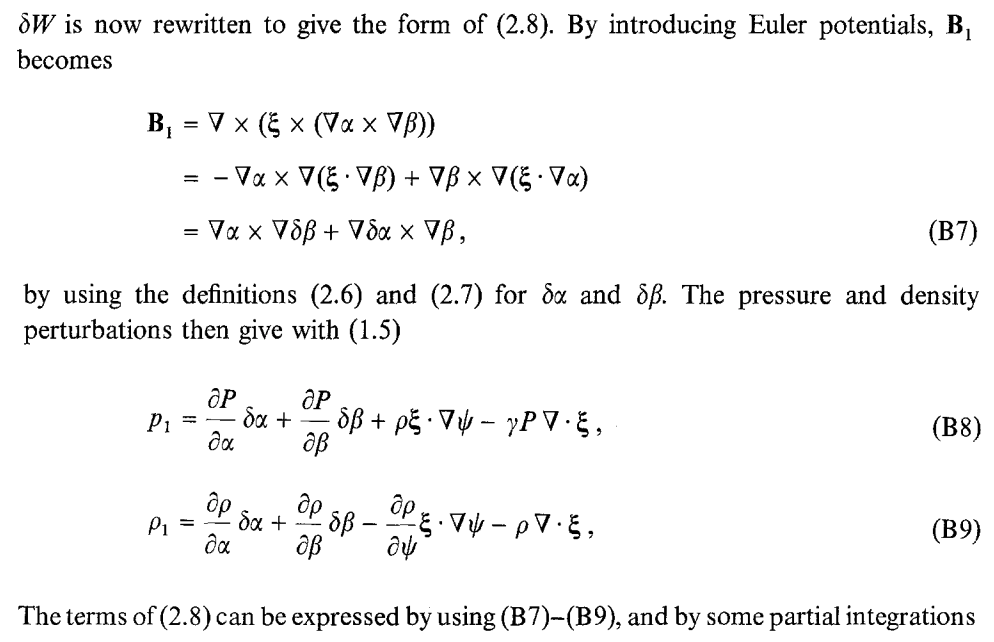

In [118]:
display(Image(filename="data/images/zwingmann.png"))

### Conclusion: the passage is mostly math notation, incorrectly scanned by OCR. 

In [119]:
example = examples.iloc[79]
pprint(f"Original sentence: {example.sent_original}")
pprint(f"Example: {example.sent_no_cit}")
print(f"Target doi: {example.citation_dois}")
print(example.pubdate)

('Original sentence: Initial Discoveries of Strong Lensing Systems The first '
 'strong lens, the double quasar 0957+561A, B, was discovered in 1979 by Walsh '
 'et al. ( 1979 ).')
('Example: Initial Discoveries of Strong Lensing Systems The first strong '
 'lens, the double quasar 0957+561A, B, was discovered in 1979 by .')
Target doi: ['10.1038/279381a0']
2024-12-01


This is the correct doi for the inline citation. It got the target doc at rank 2098. The passage refers to:
- The double quasar 0957+561A, B
- This is a strong lens
- Walsh et al first discovered it

In [120]:
results = bge_query_results[79]
walsh_result = results[2098]
pprint(walsh_result.chunk)

('The mean position of the two objects is 17 arcs from the radio position, so '
 'the identification is necessarily tentative. Table 1 Positions and '
 'magnitudes of 0957 + 561 A, B Object RA Dec (1950.0) MR MB0957 + 561 A 0957 '
 '+ 561B 095757.3 095757.4 +560822.9 +560816.9 17.0 17.0 16.7 17.0 '
 'Observations The two objects 0957 + 561 A, B were observed on 29 March 1979 '
 'at the 2.1 m telescope of the Kitt Peak National Observatory (KPNO) using '
 'the intensified image dissector scanner (IIDS). Sky subtraction was used '
 'with circular apertures separated by 99.4 arc s. Some observational '
 'parameters are given in Table 2. The spectral range was divided into 1,024 '
 'data bins, each bin 3.5 wide, and the spectral resolution was 16 A. After '
 '20-min integration on each object it was clear that both were QSOs with '
 'almost identical spectra and redshifts of -1.40 on the basis of strong '
 'emission lines identified as CIV ? 1549 and C ill] ? 1909. Further '
 'observations

The chunk directly refers to the twin quasar and observing it, but not as much to the lensing effect in this particular chunk.

What was considered more semantically relevant?

In [121]:
for i, result in enumerate(results[:3]):
    pprint(f"Rank {i} (doi {result.doi}) (distance {result.distance:.4f}): {result.chunk}")
    print()

('Rank 0 (doi 10.1088/1361-6633/ab4fc5) (distance 0.0599): Strong lensing was '
 'discovered for the first time in 1979 by Walsh et al [ 5 ]. The background '
 'source is a quasar, which is a very bright active galactic nucleus powered '
 'by a supermassive black hole at the center of a galaxy. Quasars are bright '
 'enough to be detected even at cosmological distances, and their compact '
 'sizes suggest that their multiple images are well separated, which make them '
 'as an ideal source for strong lensing. In the first example, the quasar '
 'Q0957+561 at redshift z = 1.4 is split into two images separated by due to '
 'the gravitational lensing effect of a foreground group of galaxies. The '
 'lensing interpretation was confirmed by the identical spectra of the two '
 'quasar images. Strong lensing of background galaxies has also been '
 'discovered. Since galaxies are much larger in size than quasars, lensed '
 'galaxies often form giant arcs, which are highly elongated galaxy ima

All these chunks directly refer to Walsh 1979, likely contributing strong similarity (distance ~ 0.06). Notably, Walsh 1979 has a title that might be highly relevant to this passage query.

Let's see what happens when we also embed the title and abstract

In [123]:
pprint(walsh_result.title)
pprint(walsh_result.abstract)

'0957+561 A, B: twin quasistellar objects or gravitational lens?'
('Within the field of the source 0957 + 561 is a close pair of blue stellar '
 'objects of magnitude 17 with a separation of 5.7 arc sec at redshift 1.405. '
 'The two sources show great similarity in their spectral characteristics. A '
 'conventional interpretation could regard as coincidence the similarity of '
 'emission spectra, or assume that the initial conditions, age and environment '
 'of the two quasars are practically identical. A less conventional view would '
 'find the quasars to be two images of the same object produced by a '
 'gravitational lens.')


In [128]:
title_chunk = f"Title: {walsh_result.title}\n\nBody: {walsh_result.chunk}"
abstract_chunk = f"Abstract: {walsh_result.abstract}\n\nBody: {walsh_result.chunk}"
chunk_title = f"Body: {walsh_result.chunk}\n\nTitle: {walsh_result.title}"
chunk_abstract = f"Body: {walsh_result.chunk}\n\nAbstract: {walsh_result.abstract}"
title_and_abstract = f"Title: {walsh_result.title}\n\nAbstract: {walsh_result.abstract}\n\nBody: {walsh_result.chunk}"

In [130]:
pprint(title_chunk)

('Title: 0957+561 A, B: twin quasistellar objects or gravitational lens?\n'
 '\n'
 'Body: The mean position of the two objects is 17 arcs from the radio '
 'position, so the identification is necessarily tentative. Table 1 Positions '
 'and magnitudes of 0957 + 561 A, B Object RA Dec (1950.0) MR MB0957 + 561 A '
 '0957 + 561B 095757.3 095757.4 +560822.9 +560816.9 17.0 17.0 16.7 17.0 '
 'Observations The two objects 0957 + 561 A, B were observed on 29 March 1979 '
 'at the 2.1 m telescope of the Kitt Peak National Observatory (KPNO) using '
 'the intensified image dissector scanner (IIDS). Sky subtraction was used '
 'with circular apertures separated by 99.4 arc s. Some observational '
 'parameters are given in Table 2. The spectral range was divided into 1,024 '
 'data bins, each bin 3.5 wide, and the spectral resolution was 16 A. After '
 '20-min integration on each object it was clear that both were QSOs with '
 'almost identical spectra and redshifts of -1.40 on the basis of strong

In [125]:
query_vector = bge_embedder([example.sent_no_cit])[0]

In [129]:
print(cosine_distance(query_vector, bge_embedder([title_chunk])[0]))
print(cosine_distance(query_vector, bge_embedder([abstract_chunk])[0]))
print(cosine_distance(query_vector, bge_embedder([chunk_title])[0]))
print(cosine_distance(query_vector, bge_embedder([chunk_abstract])[0]))
print(cosine_distance(query_vector, bge_embedder([title_and_abstract])[0]))

0.11602515
0.12238878
0.119539976
0.12340659
0.1124441


None of these enrichments particularly do anything to get the embedding closer to the query. What about the title and abstract by themselves?

In [131]:
title_only = bge_embedder([walsh_result.title])[0]
abstract_only = bge_embedder([walsh_result.abstract])[0]
print(cosine_distance(query_vector, title_only))
print(cosine_distance(query_vector, abstract_only))

0.13204706
0.11647391


Or any of the chunks from Walsh 1979?

In [132]:
walsh_chunks = [chunk[0] for chunk in db.query("SELECT chunk FROM lib WHERE doi = '10.1038/279381a0'")]
print(len(walsh_chunks))

14


In [133]:
walsh_embeddings = bge_embedder(walsh_chunks)
walsh_distances = [cosine_distance(walsh_embeddings[i], query_vector) for i in range(len(walsh_embeddings))]
print(f"Distances: {walsh_distances}")
closest = min(walsh_distances)
print(f"Chunk in target doc with closest embedding distance has distance: {closest}")
closest_idx = walsh_distances.index(closest)
pprint(f"Closest chunk: {walsh_chunks[closest_idx]}")

Distances: [np.float32(0.14022768), np.float32(0.12455821), np.float32(0.14882791), np.float32(0.1489079), np.float32(0.14485228), np.float32(0.15837085), np.float32(0.12893093), np.float32(0.13342458), np.float32(0.12892556), np.float32(0.15016615), np.float32(0.14718091), np.float32(0.13947636), np.float32(0.12611187), np.float32(0.14071149)]
Chunk in target doc with closest embedding distance has distance: 0.1245582103729248
('Closest chunk: The mean position of the two objects is 17 arcs from the '
 'radio position, so the identification is necessarily tentative. Table 1 '
 'Positions and magnitudes of 0957 + 561 A, B Object RA Dec (1950.0) MR MB0957 '
 '+ 561 A 0957 + 561B 095757.3 095757.4 +560822.9 +560816.9 17.0 17.0 16.7 '
 '17.0 Observations The two objects 0957 + 561 A, B were observed on 29 March '
 '1979 at the 2.1 m telescope of the Kitt Peak National Observatory (KPNO) '
 'using the intensified image dissector scanner (IIDS). Sky subtraction was '
 'used with circular ap

Here we see that the closest chunk from the target doc has a cosine distance of 0.1246, not that close, even though the passage is laying out original observations of the double quasar in question rather than citing others' work on the matter. Could an NLI mode have performed better?

### Conclusion: the embedding model found many other articles that also cited the same source with naturally similar semantic content. Perhaps an NLI reranker would have done the job